In [1]:
import pyam
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.transforms as mtransforms

from pathlib import Path

<IPython.core.display.Javascript object>

Step 1: Read in the data prepared in the notebook `101_prepare_input_data.ipynb`.

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


Step 2: Prepare the data for panel a. For this panel, we basically need the data for the following variables:
* 

In [3]:
variables = [
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',#new
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
]

In [4]:
panel_a_part_1 = (
    df
    .filter(
        variable=variables[0:2],
        region='World'
    )
)

In [5]:
panel_a_part_2 = (
    df
    .filter(
        variable=variables[2:4],
        region='World'
    )
    .convert_unit(
        current='Gt CO2/yr',
        to='Gt CO2/yr',
        factor=-1
    )
)

In [6]:
panel_a = pyam.concat(
    [
        panel_a_part_1,
        panel_a_part_2
    ]
)

In [7]:
panel_a_offset = (
    panel_a
    .filter(
        year=range(2020, 2101)
    )
    .offset(year=2020)
)

Step 3: Now let us construct a version of this data that also is a % of the total mitigation effort.

In [8]:
total_mitigation = (
    df
    .filter(
        variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
        region='World'
    )
    .timeseries()
    .reset_index()
    .drop(
        columns=[
            'variable',
            'region',
            'unit'
        ]
    )
    .set_index(['model', 'scenario'])
)

In [9]:
df.meta.loc[:,  'Year of netzero CO2 emissions (Harm-Infilled) table'].fillna(2100, inplace=True)

In [10]:
netzero = total_mitigation.apply(
    lambda x: pyam.cumulative(
        x,
        first_year=df.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table'],
        last_year=df.meta.loc[x.name[0:2], 'Year of netzero CO2 emissions (Harm-Infilled) table']
    ),
    axis=1
)

Compile the dataset we will use to compile the total mitigation effort to net zero CO2.

In [11]:
total_mitigation_small = pd.DataFrame(
    total_mitigation[2020]
)

In [12]:
total_mitigation_small['netzero'] = netzero

In [13]:
total_mitigation_diff = total_mitigation_small.diff(axis=1).dropna(axis=1)

In [14]:
total_mitigation_diff

netzero
model             scenario                          
AIM/CGE 2.0       SSP1-26                 -38.120905
                  SSP4-26                 -41.402471
AIM/CGE 2.1       CD-LINKS_NPi2020_1000   -39.564694
                  CD-LINKS_NPi2020_400    -47.248675
                  CO_Bridge               -38.802729
...                                              ...
WITCH-GLOBIOM 4.4 CD-LINKS_INDC2030i_1600 -38.739193
                  CD-LINKS_NDC2030i_1000  -40.885297
                  CD-LINKS_NPi2020_1000   -41.426124
                  CD-LINKS_NPi2020_1600   -39.927693
                  CD-LINKS_NPi2020_400    -42.811297

[407 rows x 1 columns]

In [15]:
panel_a_percent = pyam.IamDataFrame(
    panel_a_offset
    .timeseries()
    .apply(
        lambda x: x * 100/ total_mitigation_diff.loc[x.name[0:2],'netzero'],
        axis=1
    )
)

In [16]:
panel_a_percent.meta = df.meta
panel_a_offset.meta = df.meta

Step 4: Let us start some plotting

In [17]:
categories_and_colors = {
    'C1':'#4dbdab',
    'C2':'#7688ab',
    'C3':'#e74d4d'
}

In [18]:
panel_a_percent.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross']

In [19]:
df.meta.rename(
    columns={
        'Median peak warming (MAGICCv7.5.3)':'median_peak_warming'
    },
    inplace=True
)

In [20]:
df.meta.loc[:, 't_decline'] = df.meta.loc[:, 'median_peak_warming'] - df.meta.loc[:, 'Median warming in 2100 (MAGICCv7.5.3)']

In [21]:
df.meta.loc[:, 'archetype'] = df.meta.Policy_category.apply(
    lambda x: 'Immediate' if ('P2' in x or 'P0' in x) else 'Delayed'
)

In [22]:
df.meta.loc[:, 'time_until_netzero'] = (
    df.meta.loc[:, 'Year of netzero CO2 emissions (Harm-Infilled) table']
    -
    2020
)

In [23]:
df.meta.loc[:,'cumulative_cdr_2020_netzero'] = (
    df.meta.loc[:,'land_cdr_2020_netzero']
    +
    df.meta.loc[:,'novel_cdr_2020_netzero']
)

In [24]:
df.meta.loc[:, 'share_land_2020_netzero'] = (
    df.meta.loc[:,'land_cdr_2020_netzero']
    * 100
    / df.meta.loc[:,'cumulative_cdr_2020_netzero']
)

In [25]:
df.meta.loc[:, 'share_novel_cdr_netzero_2100'] = (
    (df.meta.loc[:, 'novel_cdr_netzero_2100']) *100
    /
    (df.meta.loc[:, 'novel_cdr_netzero_2100']+df.meta.loc[:, 'land_cdr_netzero_2100'])
)

In [26]:
ix_to_change = df.meta[df.meta['land_cdr_netzero_2100']<0].index
df.meta.loc[ix_to_change, 'share_novel_cdr_netzero_2100'] = 100

Now, assign the policy categories

In [27]:
delay_categories = pd.read_excel(
    Path(
        '../data/103_delay_categories.xlsx'
    ),
    index_col=[0,1]
)

In [28]:
panel_bc = pd.concat(
    [
        df.meta,
        delay_categories
    ],
    axis=1
)

In [29]:
panel_bc['category_reductions'] = panel_bc['category_reductions'].astype('category')
panel_bc['category_netzero'] = panel_bc['category_netzero'].astype('category')

In [30]:
font = {'size'   : 16}
plt.rc('font', **font)

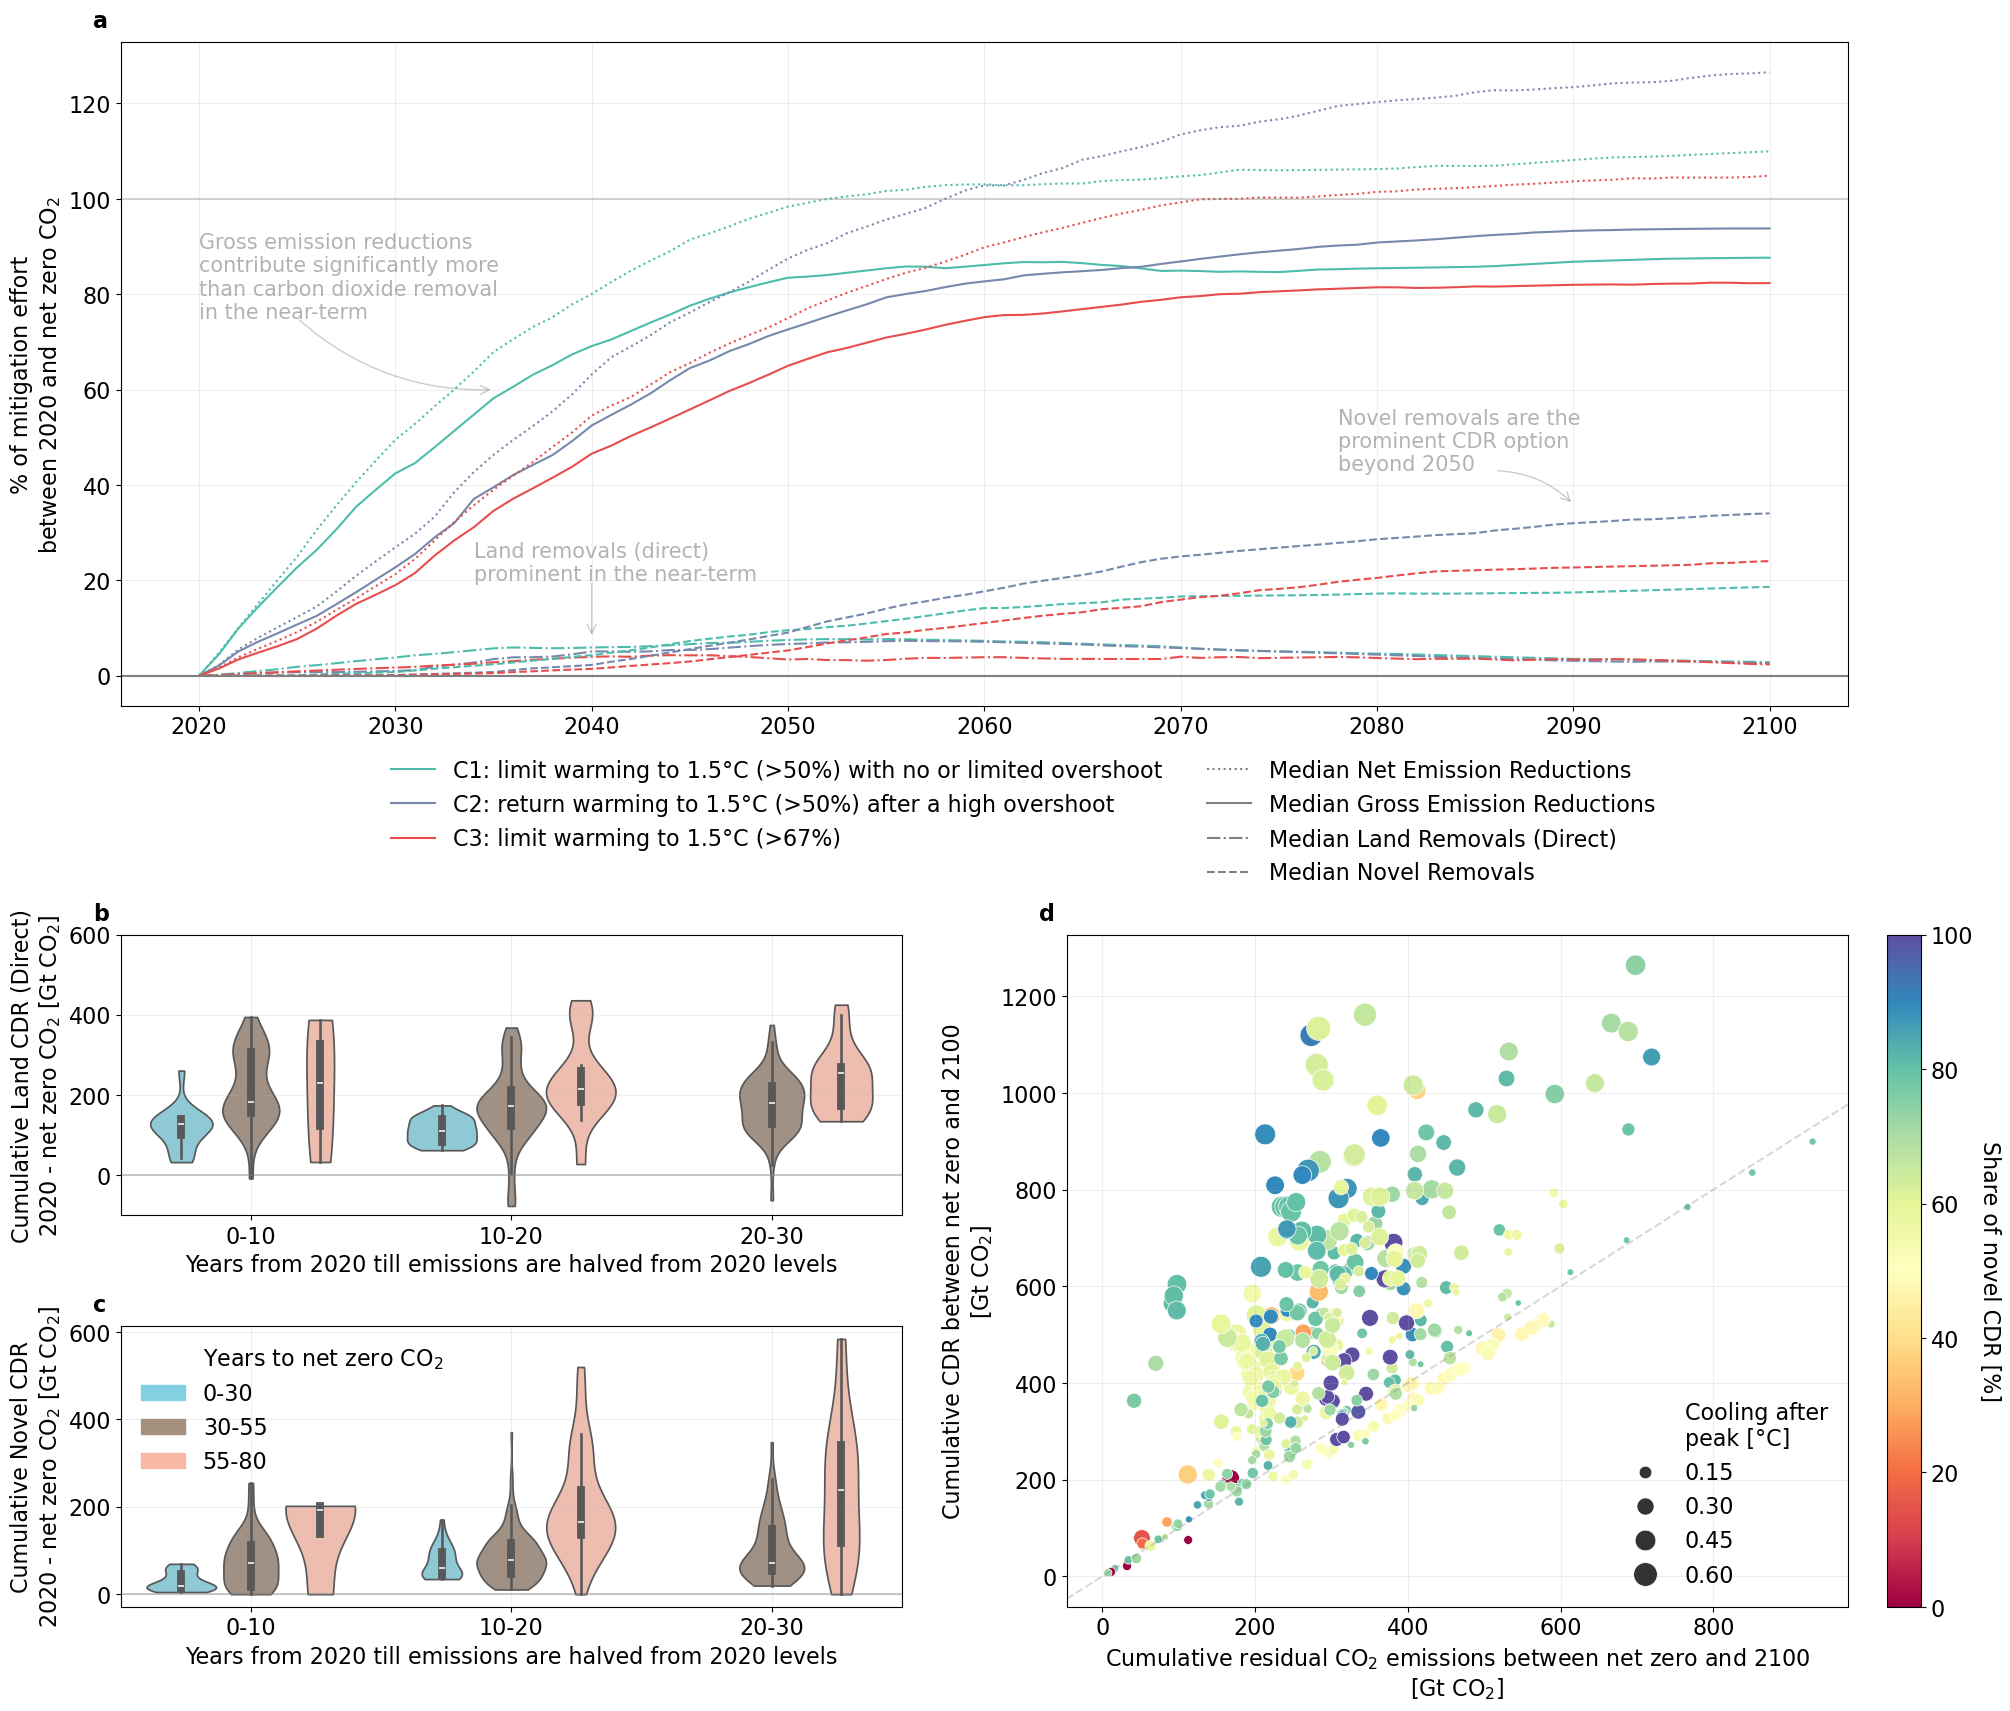

In [31]:
fig, ax = plt.subplot_mosaic(
    [
        ['a', 'a'],
        ['a', 'a'],
        ['b', 'd'],
        ['c', 'd']
    ],
    figsize=(20,17),
    constrained_layout=True
)

# Panel a: Median across the three variables
# Then we will include annotations to guide the reader
variables_and_linestyles = {
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct':'dashdot',
    'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land':'dashed',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross':'solid',
    'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only':':'   
}

for var in variables_and_linestyles.keys():
    for category in categories_and_colors.keys():
        _plot_data = (
            panel_a_percent
            .filter(
                variable=var,
                Category=category
            )
            #.convert_unit(
            #    current='Gt CO2/yr',
            #    to='Gt CO2/yr',
            #    factor=-1
            #)
            .timeseries()
            .median()
        )
        ax['a'].plot(
            _plot_data.index,
            _plot_data,
            color=categories_and_colors[category],
            linestyle=variables_and_linestyles[var]
        )
ax['a'].text(
    x=2020,
    y=75,
    s='Gross emission reductions\ncontribute significantly more\nthan carbon dioxide removal\nin the near-term',
    fontdict={
        'color':'grey',
        'alpha':0.6,
        'fontsize':15
    }
)

ax['a'].annotate(
    text='',
    xy=(2035, 60),
    xycoords='data',
    xytext=(2025, 75),
    textcoords='data',
    arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3,rad=0.2', 'color':'grey', 'alpha':0.4}
)

ax['a'].text(
    x=2034,
    y=20,
    s='Land removals (direct)\nprominent in the near-term',
    fontdict={
        'color':'grey',
        'alpha':0.6,
        'fontsize':15
    }
)

ax['a'].annotate(
    text='',
    xy=(2040, 8),
    xycoords='data',
    xytext=(2040, 20),
    textcoords='data',
    arrowprops={'arrowstyle':'->', 'color':'grey', 'alpha':0.4}
)

ax['a'].text(
    x=2078,
    y=43,
    s='Novel removals are the\nprominent CDR option\nbeyond 2050',
    fontdict={
        'color':'grey',
        'alpha':0.6,
        'fontsize':15
    }
)

ax['a'].annotate(
    text='',
    xy=(2090, 36),
    xycoords='data',
    xytext=(2086, 43),
    textcoords='data',
    arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3,rad=-0.2', 'color':'grey', 'alpha':0.4}
)
ax['a'].axhline(0, color='grey')
ax['a'].set_ylabel('% of mitigation effort\nbetween 2020 and net zero CO$_2$')

# Panel b - Cumulative removals until net zero land
b = sns.violinplot(
    data=panel_bc,
    x='category_reductions',
    y='land_cdr_2020_netzero',
    ax=ax['b'],
    hue='category_netzero',
    cut=0,
    palette=[
        '#83d0e2',
        '#a5917f',
        '#f7b9a6'
    ],
    legend=False
)
b.set_xlabel('Years from 2020 till emissions are halved from 2020 levels')
b.set_ylabel('Cumulative Land CDR (Direct)\n2020 - net zero CO$_2$ [Gt CO$_2$]')
ax['b'].axhline(0, color='grey', alpha=0.4)
ax['b'].set_ylim(-100, 600)
ax['c'].axhline(0, color='grey', alpha=0.4)


c = sns.violinplot(
    data=panel_bc,
    x='category_reductions',
    y='novel_cdr_2020_netzero',
    ax=ax['c'],
    hue='category_netzero',
    palette=[
        '#83d0e2',
        '#a5917f',
        '#f7b9a6'
    ],
    cut=0,
    legend=False
)
c.set_xlabel('Years from 2020 till emissions are halved from 2020 levels')
c.set_ylabel('Cumulative Novel CDR\n2020 - net zero CO$_2$ [Gt CO$_2$]')

# Panel c - scatter
d = sns.scatterplot(
    size='t_decline',
    y='cumulative_cdr_netzero_2100',
    #style='Category',
    ax=ax['d'],
    data=df.meta,
    x='cumulative_gross_netzero_2100',
    #hue='median_peak_warming',
    hue='share_novel_cdr_netzero_2100',
    palette='Spectral',
    sizes=(20, 300)
)

#Colormap
norm = plt.Normalize(
    df.meta['share_novel_cdr_netzero_2100'].min(),
    df.meta['share_novel_cdr_netzero_2100'].max()
)
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)

cbar = d.figure.colorbar(sm, ax=ax['d'])
cbar.ax.set_ylabel('Share of novel CDR [%]', rotation=270, labelpad=20) 

#ax['c'].set_xlabel('T(peak) - T(2100) [°C]')
ax['d'].set_xlabel('Cumulative residual CO$_2$ emissions between net zero and 2100\n[Gt CO$_2$]')
ax['d'].set_ylabel('Cumulative CDR between net zero and 2100\n[Gt CO$_2$]')
h, l = d.get_legend_handles_labels()
#l[7] = 'Cumulative\ngross CO$_2$'
l[7] = 'Cooling after\npeak [°C]'
ax['d'].legend(h[7:], l[7:], ncol=1, framealpha=0.0, loc=4)
#ax['c'].legend.get_frame().set_facecolor('none')
ax['d'].axline((0, 0), (1, 1),color='grey', linestyle='dashed', alpha=0.3)

# Add a custom legend for this graph
custom_legend = [
   # Line2D([0], [0], color='w', label='Panel a'),
    Line2D([0], [0], color=categories_and_colors['C1'], label='C1: limit warming to 1.5°C (>50%) with no or limited overshoot'),
    Line2D([0], [0], color=categories_and_colors['C2'], label='C2: return warming to 1.5°C (>50%) after a high overshoot'),
    Line2D([0], [0], color=categories_and_colors['C3'], label='C3: limit warming to 1.5°C (>67%)'),
    Line2D([0], [0], color='white', label=''),
    #Line2D([0], [0], color='w', label=''),
    Line2D([0], [0], color='grey', linestyle='dotted', label='Median Net Emission Reductions'),
    Line2D([0], [0], color='grey', label='Median Gross Emission Reductions'),
    Line2D([0], [0], color='grey', linestyle='dashdot', label='Median Land Removals (Direct)'),
    Line2D([0], [0], color='grey', linestyle='dashed', label='Median Novel Removals'),
]
ax['a'].legend(handles=custom_legend,bbox_to_anchor=(0.9, -0.05),ncol=2, framealpha=0.0,)

second_custom_legend = [
    Patch(facecolor='w', edgecolor='w', label='Years to net zero CO$_2$'),
    Patch(facecolor='#83d0e2', edgecolor='#83d0e2', label='0-30'),
    Patch(facecolor='#a5917f', edgecolor='#a5917f', label='30-55'),
    Patch(facecolor='#f7b9a6', edgecolor='#f7b9a6', label='55-80'),
]
ax['c'].legend(handles=second_custom_legend, framealpha=0.0, ncol=1)

## For panel a - make additional annotations
ax['a'].axhline(100, color='grey', alpha=0.3)

for lab,a in ax.items():
    a.grid(alpha=0.2)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    a.text(0.0, 1.0, lab, transform=a.transAxes + trans,
             va='bottom', weight='bold')

In [32]:
fig.savefig(
    Path(
        'figures/fig1.png'
    ),
    dpi=400,
    bbox_inches='tight'
)

Statements
1. The gross CO2 emission contribution (maximum)

In [33]:
panel_a_percent.variable

['AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct',
 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only',
 'AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross']

In [34]:
for clim_category in ['C1', 'C2', 'C3']:
    max_gross_cont = (
        panel_a_percent
        .filter(
            variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Gross',
            Category=clim_category
        )
        .timeseries()
        .max(axis=1)
        .round(0)
    )
    print(
        f'{clim_category} Median {max_gross_cont.median()}%, [{max_gross_cont.quantile(q=0.25)}, {max_gross_cont.quantile(q=0.75)} % interquartile range]'
    )

C1 Median 90.0%, [87.0, 95.75 % interquartile range]
C2 Median 94.0%, [88.0, 97.0 % interquartile range]
C3 Median 85.0%, [77.0, 91.0 % interquartile range]


2. Year when 50% of the mitigation effort is achieved.

In [35]:
for clim_category in ['C1', 'C2', 'C3']:
    data = (
        panel_a_percent
        .filter(
            Category=clim_category,
            variable='AR6 Reanalysis|OSCARv3.2|Emissions|CO2|Direct Only'
        )
        .timeseries()
    )
    year_50_perc = (
        data.apply(
            lambda x: x[x>=50].index.min(),
            axis=1
        )
    )
    print(
        f'{clim_category} median {year_50_perc.median()}, [{year_50_perc.quantile(q=0.25)}, {year_50_perc.quantile(q=0.75)} interquartile range]'
    )

C1 median 2030.5, [2029.0, 2033.0 interquartile range]
C2 median 2037.0, [2034.0, 2039.0 interquartile range]
C3 median 2039.0, [2036.0, 2041.0 interquartile range]


2. Land-based removals

In [36]:
for clim_category in ['C1', 'C2', 'C3']:
    data = (
        panel_a_percent
        .filter(
            Category=clim_category,
            variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land|Direct'
        )
        .timeseries()
    )

    data_max = (
        data
        .max(axis=1)
        .round(0)
    )

    data_max_timing = (
        data.apply(
            lambda x: x[x==x.max()].index.min(),
            axis=1
        )
    )

    print(
        f'{clim_category} {data_max.median()}, [{data_max.quantile(q=0.25)}, {data_max.quantile(q=0.75)} interquartile range]'
    )

    print(
        f'{clim_category} {data_max_timing.median()}, [{data_max_timing.quantile(q=0.25)}, {data_max_timing.quantile(q=0.75)} interquartile range]'
    )

C1 8.0, [7.0, 11.0 interquartile range]
C1 2051.0, [2032.0, 2056.0 interquartile range]
C2 8.0, [4.0, 9.0 interquartile range]
C2 2051.0, [2037.25, 2061.0 interquartile range]
C3 8.0, [3.0, 10.0 interquartile range]
C3 2061.0, [2032.0, 2070.0 interquartile range]


4. Novel removals

In [37]:
for clim_category in ['C1', 'C2', 'C3']:
    data = (
        panel_a_percent
        .filter(
            Category=clim_category,
            variable='AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
        )
        .timeseries()
    )

    data_max = (
        data
        .max(axis=1)
        .round(0)
    )

    data_max_timing = (
        data.apply(
            lambda x: x[x==x.max()].index.min(),
            axis=1
        )
    )

    print(
        f'{clim_category} {data_max.median()}, [{data_max.quantile(q=0.25)}, {data_max.quantile(q=0.75)} interquartile range]'
    )

    print(
        f'{clim_category} {data_max_timing.median()}, [{data_max_timing.quantile(q=0.25)}, {data_max_timing.quantile(q=0.75)} interquartile range]'
    )

C1 19.0, [14.25, 33.0 interquartile range]
C1 2100.0, [2070.0, 2100.0 interquartile range]
C2 34.0, [25.25, 40.75 interquartile range]
C2 2100.0, [2100.0, 2100.0 interquartile range]
C3 24.0, [16.0, 34.0 interquartile range]
C3 2100.0, [2100.0, 2100.0 interquartile range]


5. Novel removals share

In [38]:
(
    df
    .meta['share_novel_cdr_netzero_2100']
    .describe()
    .round(0)
)

count    393.0
mean      67.0
std       16.0
min        0.0
25%       58.0
50%       66.0
75%       79.0
max      100.0
Name: share_novel_cdr_netzero_2100, dtype: float64

Save out the total mitigation dataframe

In [39]:
total_mitigation_diff.to_excel(
    Path(
        '../data/201_total_mitigation_netzero.xlsx'
    ),
    merge_cells=False
)